In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.width', 1400)

In [72]:
def str_to_list(s):
    for c in "'[]\"":
        s = s.replace(c, '')
    return s.split(', ')

In [110]:
# Load ratings
df_interact = pd.read_csv('dataset/RAW_interactions.csv')

# Load recipes
df_recipes = pd.read_csv('dataset/RAW_recipes.csv')
df_recipes.set_index('id', inplace=True)
for k in ['tags', 'ingredients', 'steps', 'nutrition']:
    df_recipes[k] = df_recipes[k].apply(str_to_list) # convert str to list
df_recipes['nutrition'] = df_recipes['nutrition'].apply( lambda array: [ float(y) for y in array ] )
df_recipes['n_tags'] = df_recipes['tags'].apply( lambda tags: len(tags) ) # add n_tags column

In [105]:
print(df_recipes.head())
print(df_interact.head())
print(len(df_recipes))
print(len(df_interact))

                                              name  minutes  contributor_id   submitted                                               tags                                   nutrition  n_steps                                              steps                                        description                                        ingredients  n_ingredients
id                                                                                                                                                                                                                                                                                                                                                                     
137739  arriba   baked winter squash mexican style       55           47892  2005-09-16  [60-minutes-or-less, time-to-make, course, mai...       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11  [make a choice and proceed with recipe, depend...  autumn is my favorite time of year t

In [106]:
print(df_recipes.loc[112140]['tags'])

['time-to-make', 'course', 'preparation', 'main-dish', 'chili', 'crock-pot-slow-cooker', 'dietary', 'equipment', '4-hours-or-less']


#### **1. Initial Data Exploration:** Explore the distribution of recipes based on key features such as minutes, tags, n_steps, and n_ingredients, and visualize the distribution of recipes for each of these features. 

In [ ]:
mins = sorted((df_recipes['minutes']), reverse=1)
print(f'{len(mins):_}')
print('Recipes with 0 minutes:', len([ x for x in mins if x == 0 ]))
th = 160
mins[:100]

217198


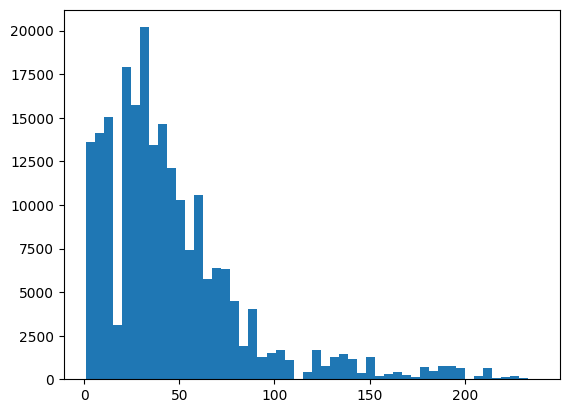

In [108]:
# Visualize dist of recipe minutes
mins_fil = [ x for x in df_recipes['minutes'] if (0 < x and x < 60*4) ]
print(len(mins_fil))
plt.hist(mins_fil, bins=50)
plt.show()

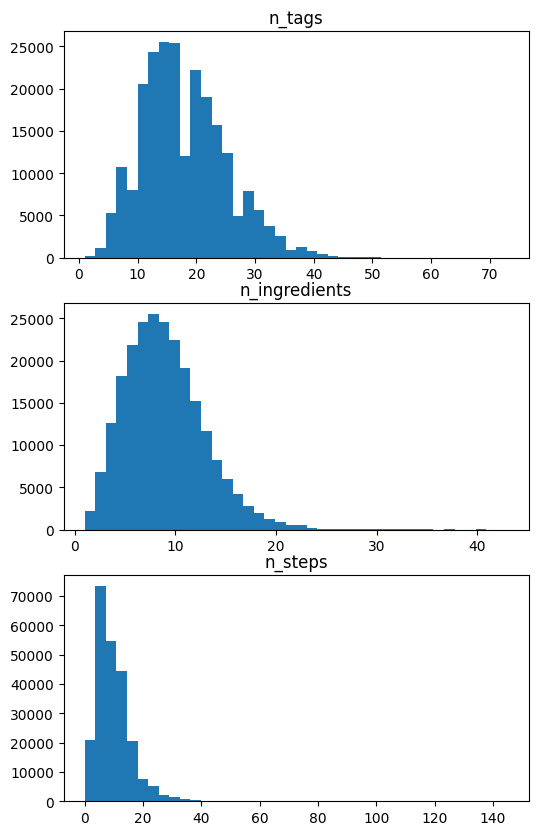

In [111]:
# 
fig, ax = plt.subplots(3, 1, figsize=(6,10))
for i, key in enumerate(['n_tags', 'n_ingredients', 'n_steps']):
    ax[i].hist(df_recipes[key], bins=40)
    ax[i].set_title(key)
plt.show()

#### 2. **User Profile Generation:** Using the two datasets, RAW_recipes.csv and RAW_interactions.csv, create a new dataset named User_Data.csv, where each row corresponds to a user in the system. The columns should include rated_recipes (a list of all recipes rated by the user), ingredients (a list of all ingredients in the recipes rated by the user), and rating_list (the list of ratings given by the user). Based on this generated user profile, explore the distribution of users across key features such as the number of rated items, the total number of ingredients per user, and the average of recorded ratings. Visualize the distribution of users for each of these features. 

In [117]:
# 
users = {}
total = len(df_interact)
for i, row in enumerate(df_interact.itertuples()):
    print('\rHandling row {:_} ({:.1f}%)'.format(i+1, (i+1)/total*100), end='')
    obj = users.get(row.user_id, {})
    if obj == {}:
        obj['user_id'] = row.user_id
        for k in ['rated_recipes', 'ingredients', 'rating_list']:
            obj[k] = []
    obj['rated_recipes'].append(row.recipe_id)
    obj['rating_list'].append(row.rating)
    recipe = df_recipes.loc[row.recipe_id]
    for ing in recipe.ingredients:
        if ing not in obj['ingredients']:
            obj['ingredients'].append(ing)
    users[row.user_id] = obj
    if i >= 100_000:
        break
# users

Handling row 100_001 (8.8%)

In [116]:
# 
df_userdata = pd.DataFrame(users.values())
df_userdata.set_index('user_id', inplace=True)
df_userdata.to_csv('dataset/User_Data.csv')
df_userdata

,rated_recipes,ingredients,rating_list
user_id,,,
38094,"[40893, 16954, 40753]","[great northern beans, yellow onion, diced gre...","[4, 5, 5]"
1293707,"[40893, 134316, 39446, 253891]","[great northern beans, yellow onion, diced gre...","[5, 5, 5, 5]"
8937,"[44394, 39230]","[devils food cake mix, vegetable oil, eggs, re...","[4, 4]"
126440,"[85009, 379639, 379102, 45539, 53594, 210456, ...","[mayonnaise, salsa, cheddar cheese, refried be...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, ..."
57222,"[85009, 434181, 34233, 443705, 122826, 112378,...","[mayonnaise, salsa, cheddar cheese, refried be...","[5, 5, 4, 5, 4, 5, 4, 4, 4, 4, 5, 0, 4, 5, 5, ..."
...,...,...,...
2001674245,[63689],"[ground beef, celery, onion, tomato sauce, ket...",[5]
2001570864,[63689],"[ground beef, celery, onion, tomato sauce, ket...",[5]
2001997977,[63689],"[ground beef, celery, onion, tomato sauce, ket...",[4]
